In [ ]:
import tensorflow as tf
import statistics
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from multivariate_data import multivariate_data
from plot_train_history import plot_train_history
from multi_step_plot import multi_step_plot


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

df = pd.read_csv('weather3.csv')


TRAIN_SPLIT = 60000
tf.random.set_seed(13)

BATCH_SIZE = 512
BUFFER_SIZE = 60000
EVALUATION_INTERVAL = 150
EPOCHS = 30


def create_time_steps(length):
    return list(range(-length + 1, + 1))


features_considered = ['temp', 'hum', 'airpr', 'solrad', 'windvel']


features = df[features_considered]
features.index = df['date']


dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)


dataset = (dataset-data_mean)/data_std


past_history = 48
future_target = 12
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)


train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, kernel_regularizer=l2(0.005), 
                                          recurrent_regularizer=l2(0.005), bias_regularizer=l2(0.005), 
                                          return_sequences=True, input_shape=x_train_multi.shape[-2:]))

multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))


multi_step_model.add(tf.keras.layers.Dense(12))

multi_step_model.compile(optimizer='adam', loss='mse')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

#winddir disregarded
#20 EPOCHS á 100 EVALUATION INTERVALS
#TARGET = 24 hours

#++++++++++++++++++++++++++++++++++++

#Not too many neurons to not overfit! Not too few to not underfit!
#More than one hidden layer leads to exploding gradient!
#More hidden layers can decrease chance of underfit
#Too low regularizer (~ 0.001) tends to cause underfit!

#winddir disregarded
#30 EPOCHS á 150 EVALUATION INTERVALS
#TARGET = 12 hours
#HISTORY = 48
#Adding l2 Regularizer of 0.005 to avoid overfitting
#BATCH SIZE = 512
#BUFFER SIZE = 60000

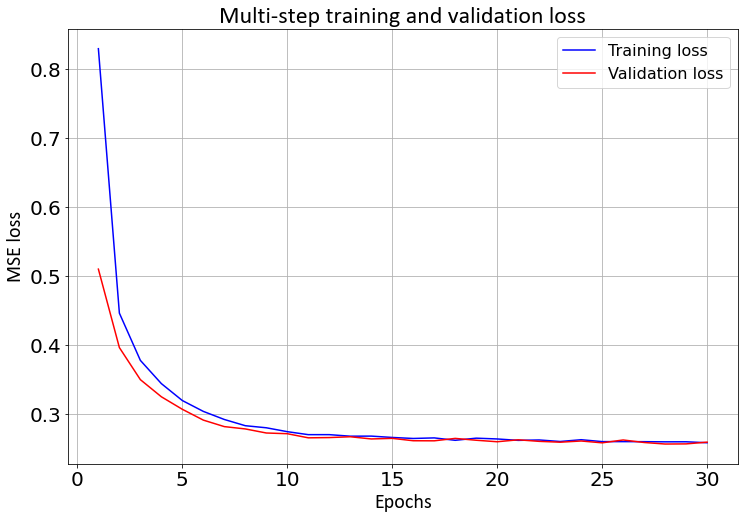

In [15]:
plot_train_history(multi_step_history, 'Multi-step training and validation loss')


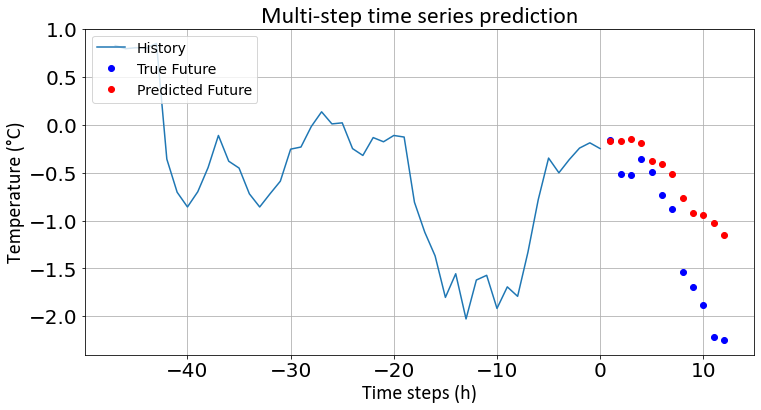

RMSE: 0.661
MAE: 0.540
ME: 1.189
SD: 0.661


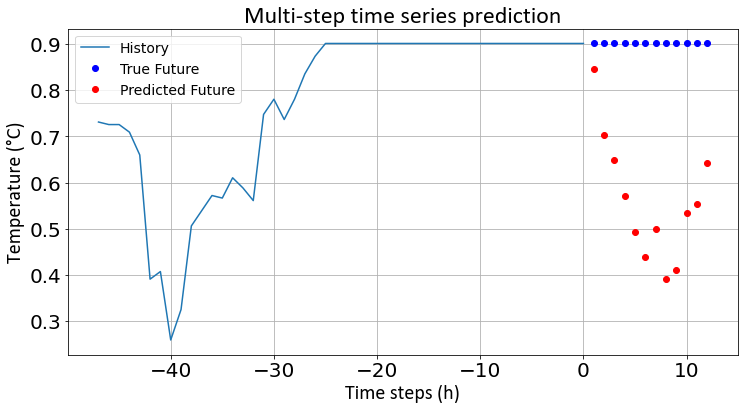

RMSE: 0.363
MAE: 0.340
ME: 0.510
SD: 0.363


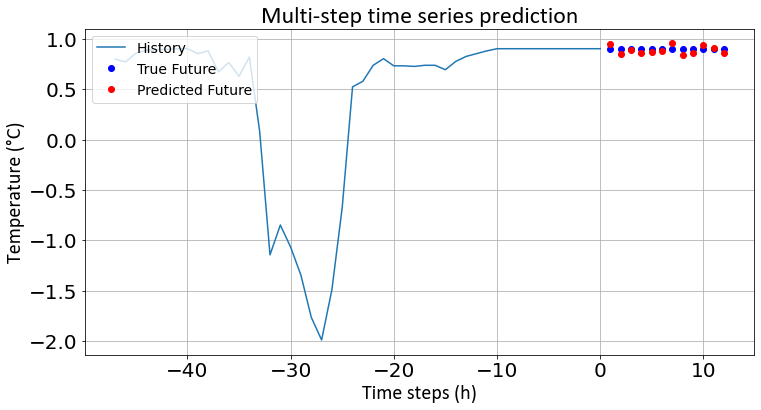

RMSE: 0.040
MAE: 0.037
ME: 0.066
SD: 0.040


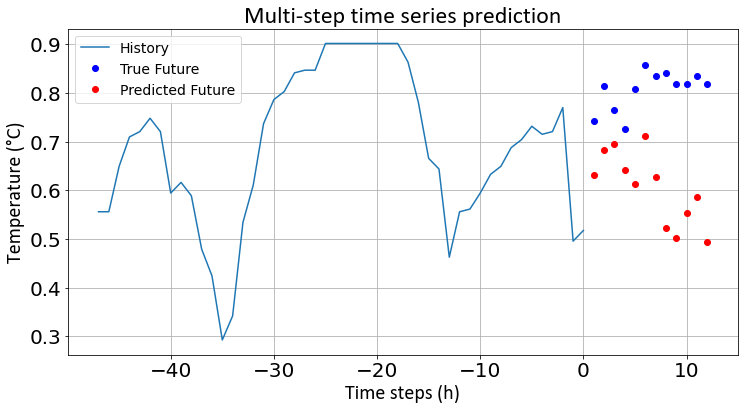

RMSE: 0.221
MAE: 0.202
ME: 0.326
SD: 0.221


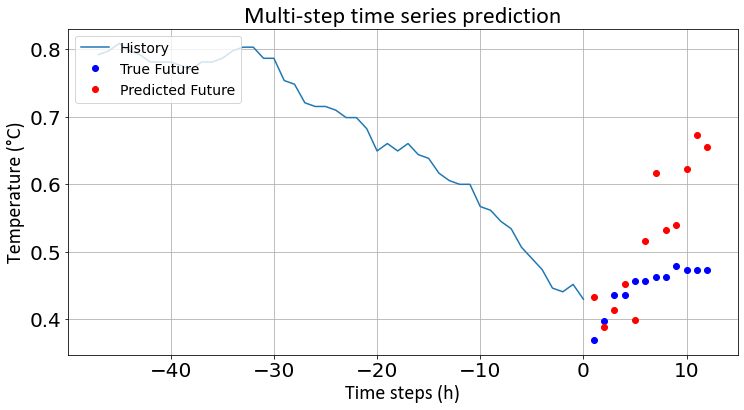

RMSE: 0.107
MAE: 0.086
ME: 0.199
SD: 0.107


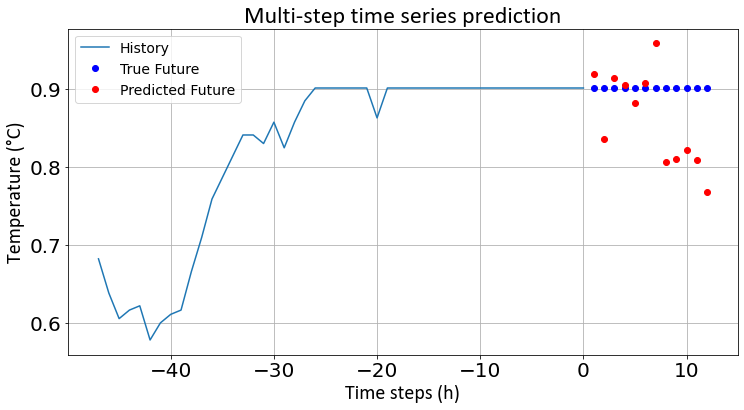

RMSE: 0.070
MAE: 0.056
ME: 0.133
SD: 0.070


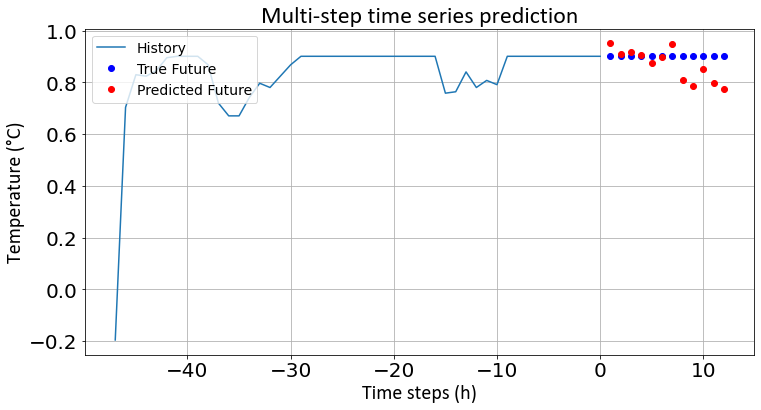

RMSE: 0.069
MAE: 0.054
ME: 0.128
SD: 0.069


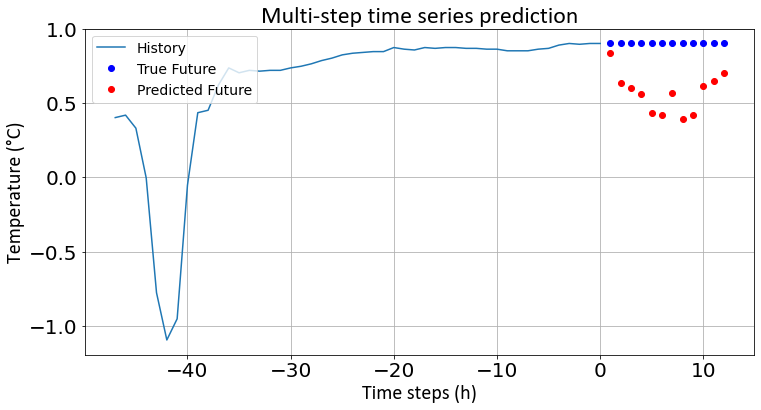

RMSE: 0.355
MAE: 0.331
ME: 0.510
SD: 0.355


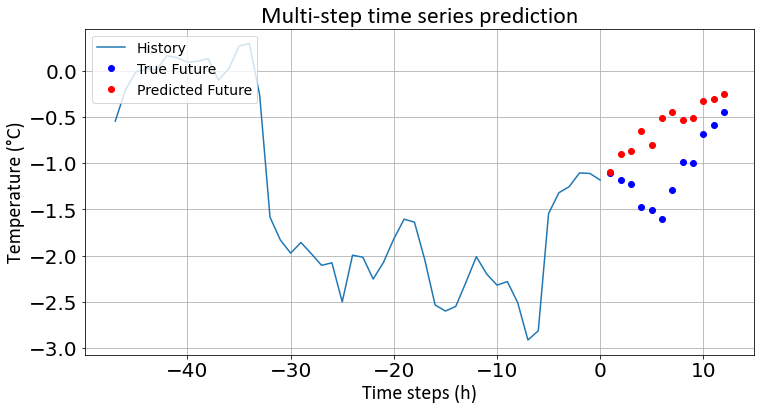

RMSE: 0.572
MAE: 0.488
ME: 1.083
SD: 0.572


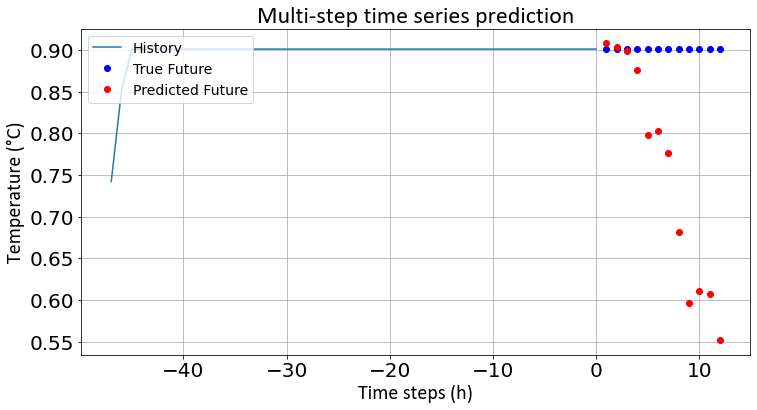

RMSE: 0.198
MAE: 0.152
ME: 0.349
SD: 0.198


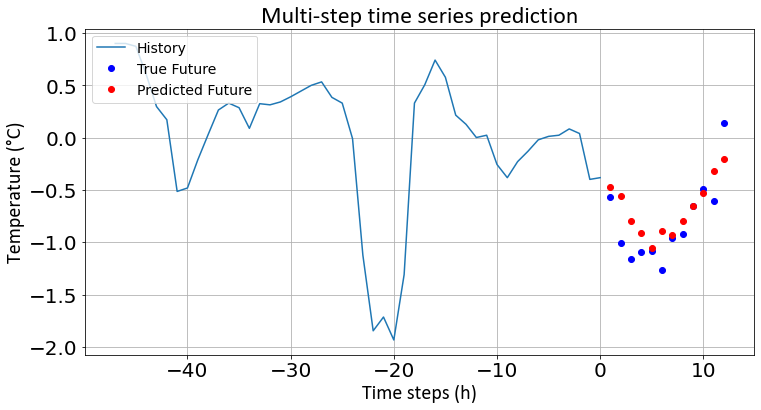

RMSE: 0.249
MAE: 0.195
ME: 0.451
SD: 0.249


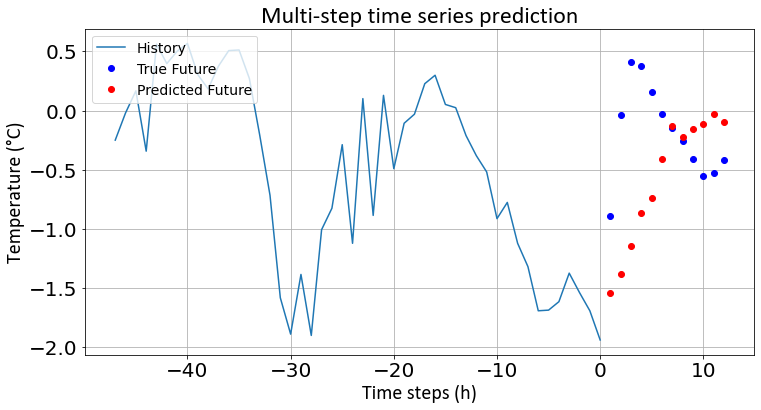

RMSE: 0.804
MAE: 0.636
ME: 1.561
SD: 0.804


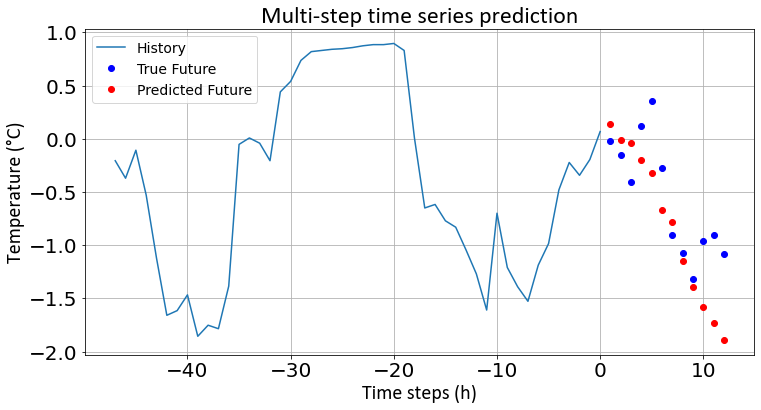

RMSE: 0.468
MAE: 0.380
ME: 0.829
SD: 0.468


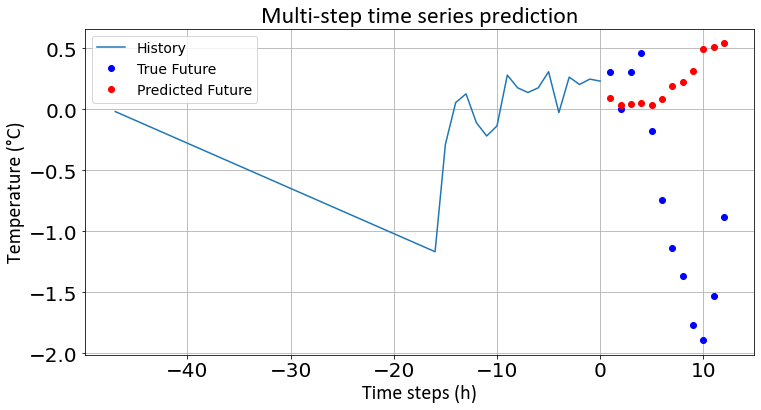

RMSE: 1.340
MAE: 1.067
ME: 2.387
SD: 1.340


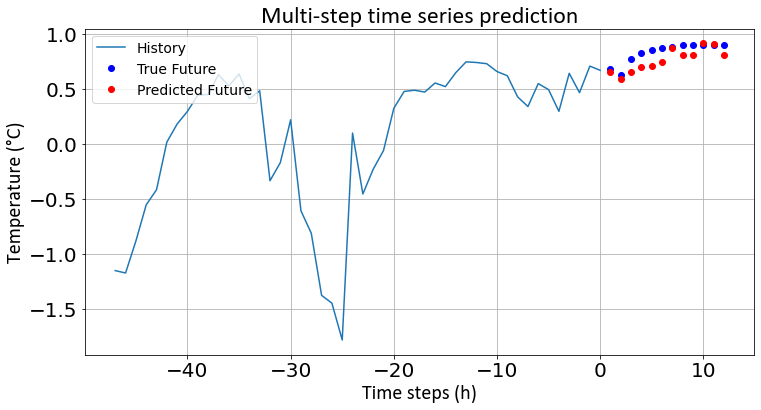

RMSE: 0.088
MAE: 0.074
ME: 0.143
SD: 0.088


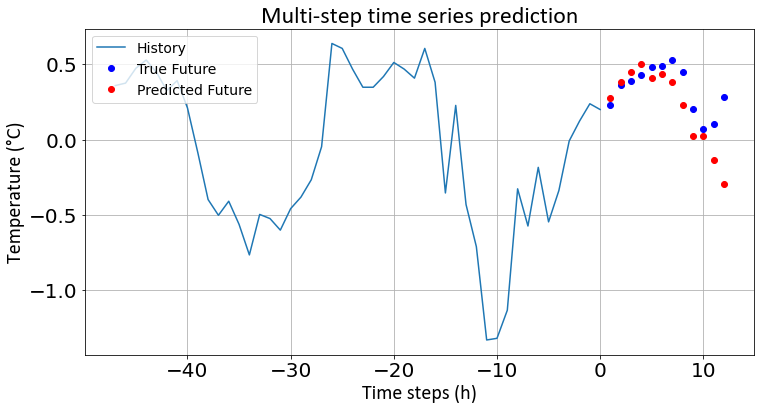

RMSE: 0.208
MAE: 0.145
ME: 0.578
SD: 0.208


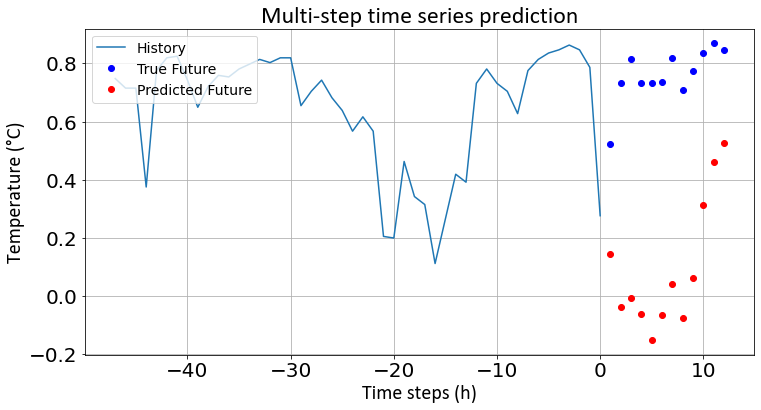

RMSE: 0.691
MAE: 0.664
ME: 0.882
SD: 0.691


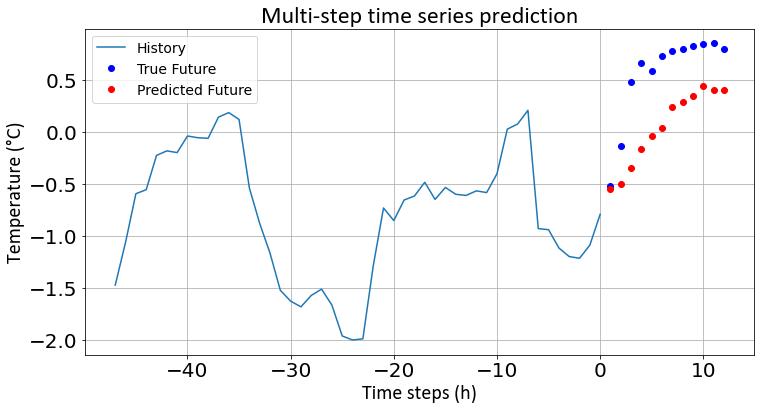

RMSE: 0.551
MAE: 0.510
ME: 0.829
SD: 0.551


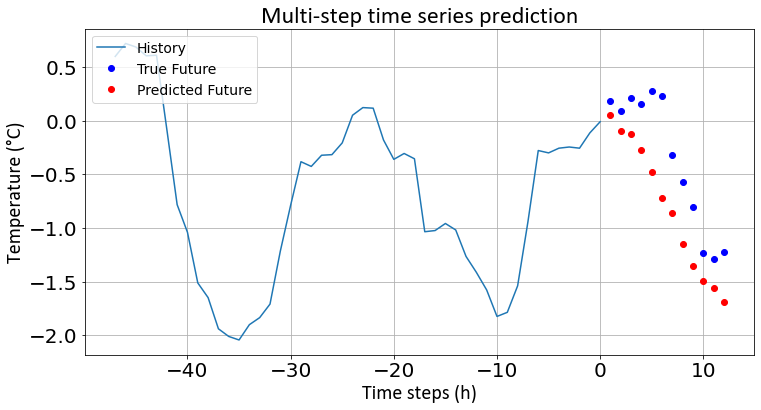

RMSE: 0.508
MAE: 0.454
ME: 0.951
SD: 0.508


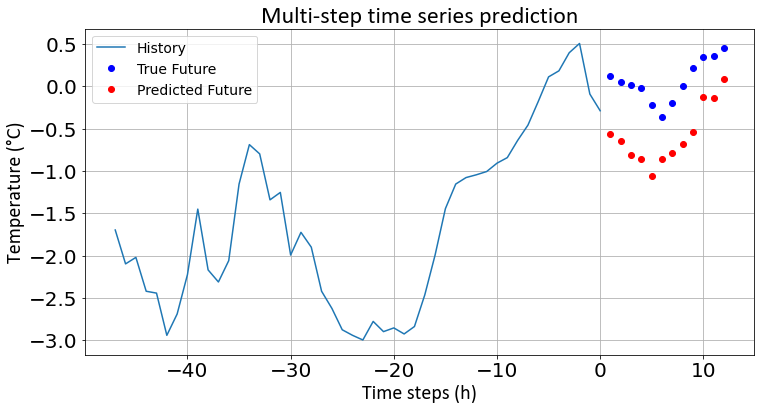

RMSE: 0.663
MAE: 0.646
ME: 0.834
SD: 0.663


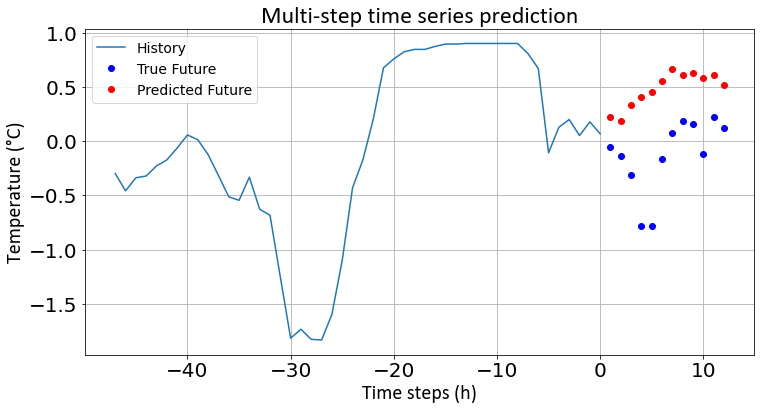

RMSE: 0.683
MAE: 0.613
ME: 1.233
SD: 0.683


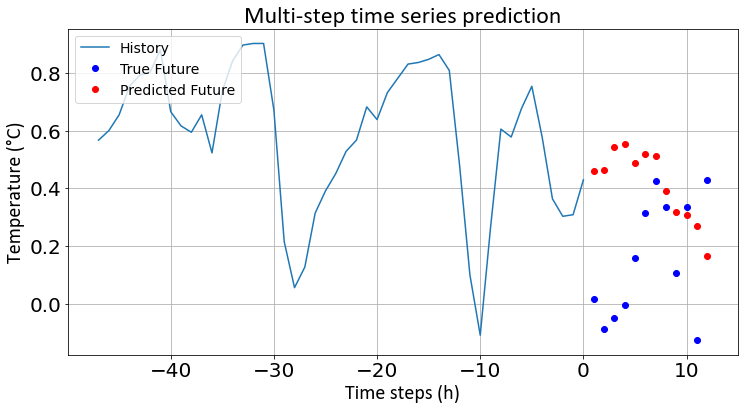

RMSE: 0.364
MAE: 0.310
ME: 0.592
SD: 0.364


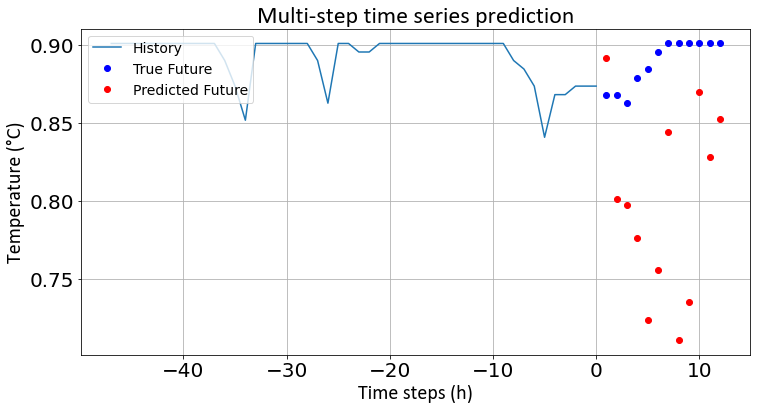

RMSE: 0.109
MAE: 0.094
ME: 0.191
SD: 0.109


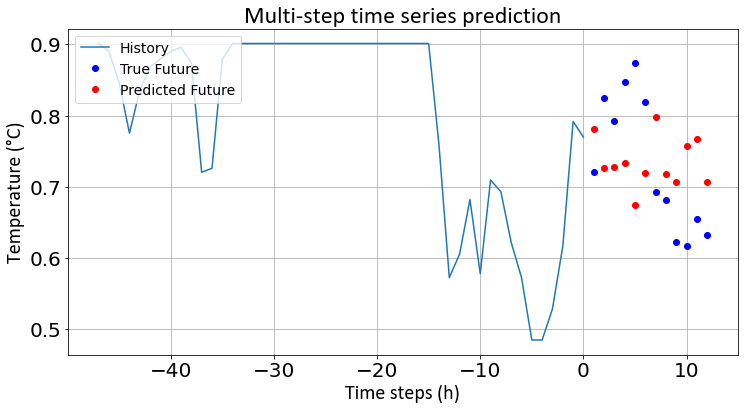

RMSE: 0.107
MAE: 0.099
ME: 0.200
SD: 0.107


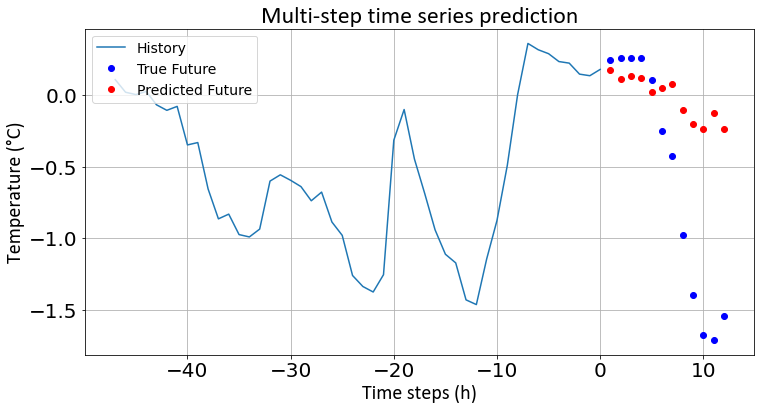

RMSE: 0.858
MAE: 0.645
ME: 1.580
SD: 0.858


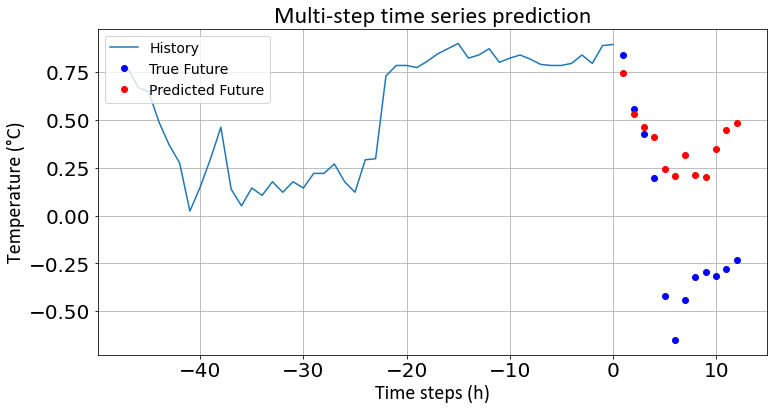

RMSE: 0.564
MAE: 0.482
ME: 0.856
SD: 0.564


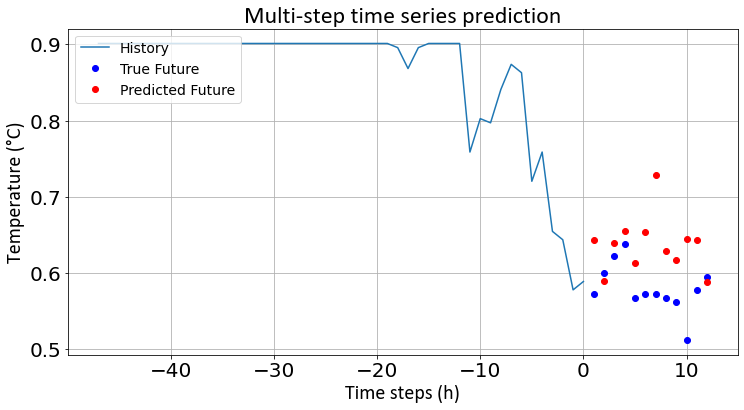

RMSE: 0.075
MAE: 0.060
ME: 0.157
SD: 0.075


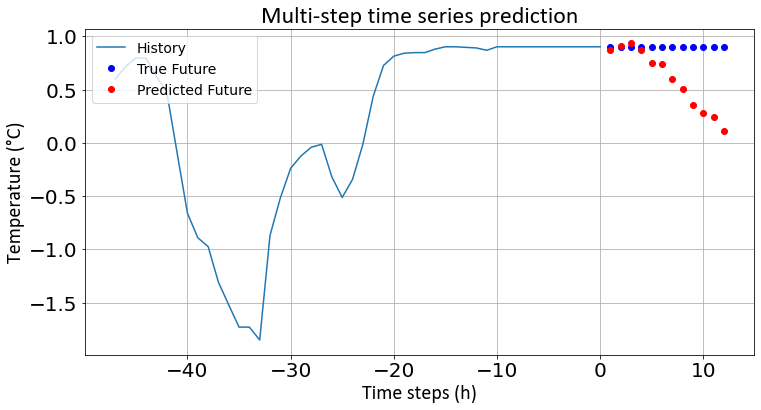

RMSE: 0.412
MAE: 0.310
ME: 0.789
SD: 0.412


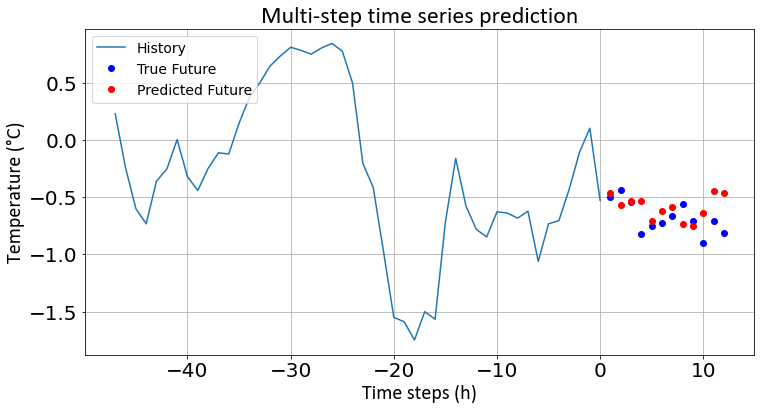

RMSE: 0.184
MAE: 0.147
ME: 0.349
SD: 0.184


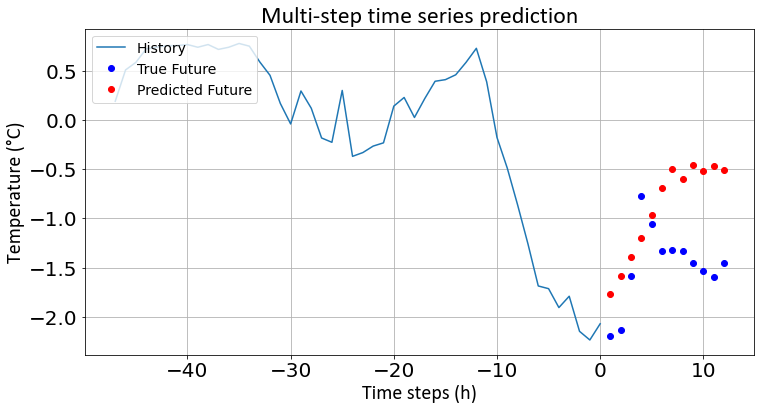

RMSE: 0.735
MAE: 0.662
ME: 1.127
SD: 0.735


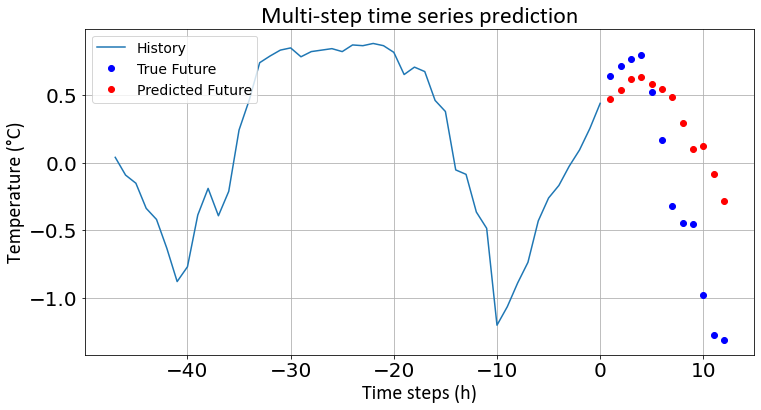

RMSE: 0.675
MAE: 0.544
ME: 1.195
SD: 0.675


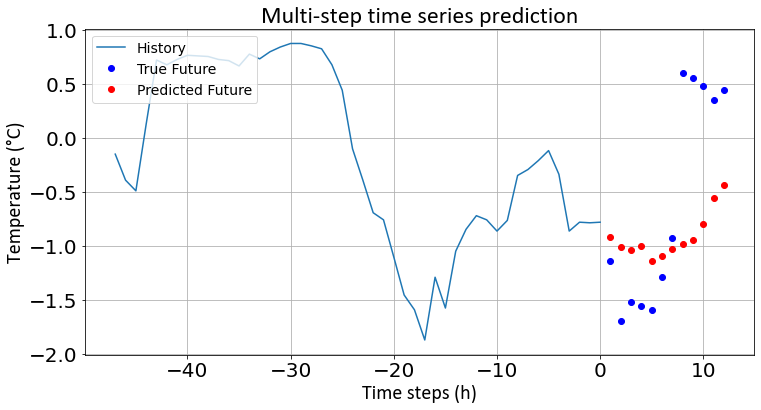

RMSE: 0.880
MAE: 0.736
ME: 1.584
SD: 0.880


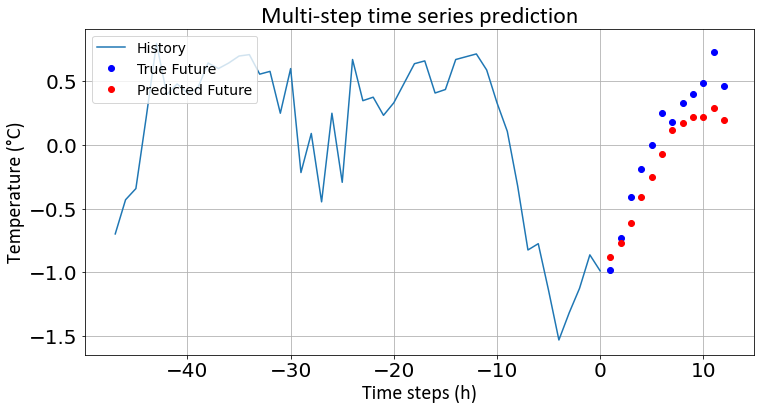

RMSE: 0.237
MAE: 0.210
ME: 0.441
SD: 0.237


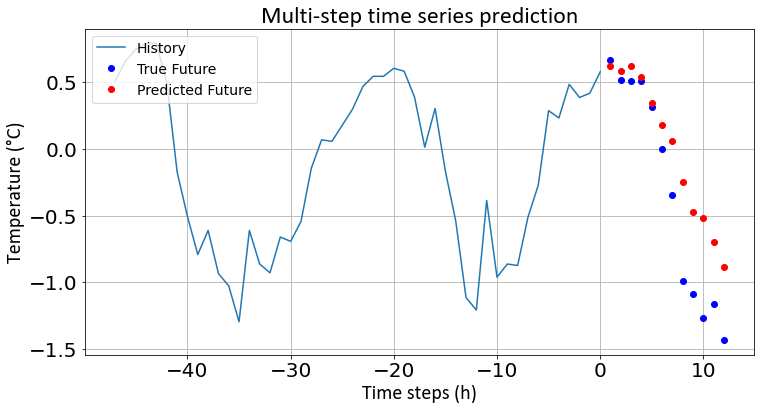

RMSE: 0.431
MAE: 0.332
ME: 0.752
SD: 0.431


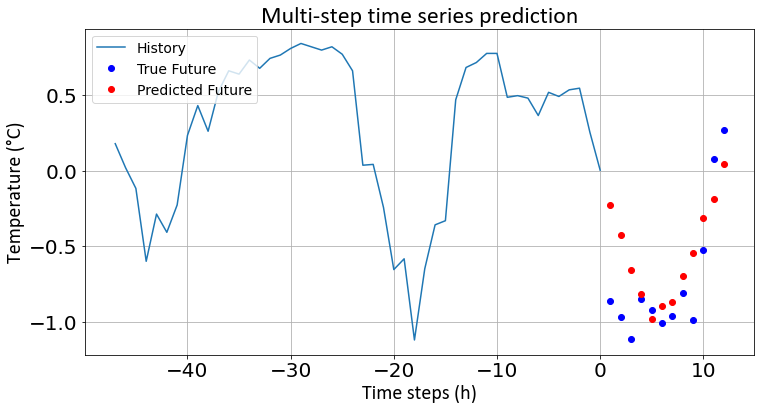

RMSE: 0.329
MAE: 0.265
ME: 0.634
SD: 0.329


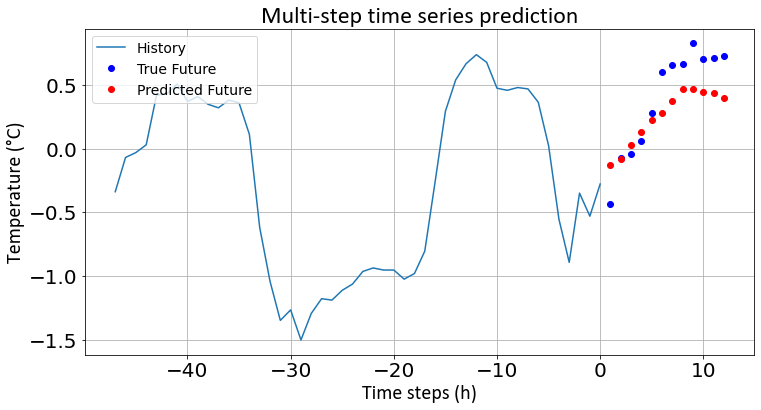

RMSE: 0.242
MAE: 0.210
ME: 0.355
SD: 0.242


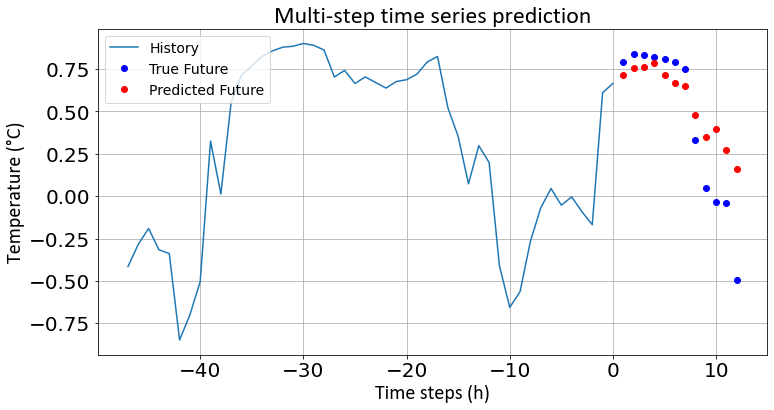

RMSE: 0.270
MAE: 0.202
ME: 0.657
SD: 0.270


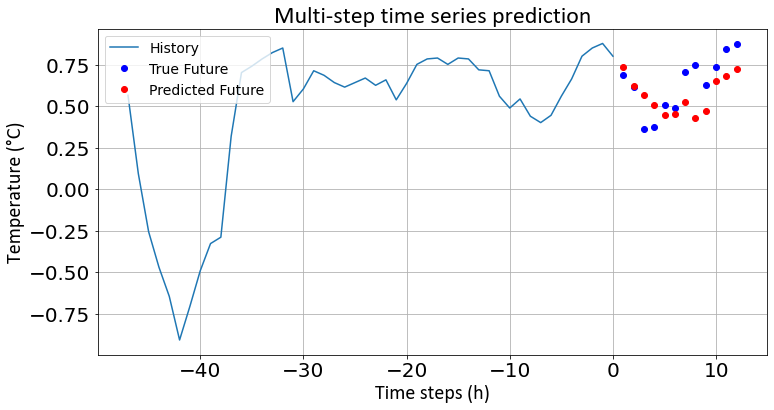

RMSE: 0.153
MAE: 0.128
ME: 0.318
SD: 0.153


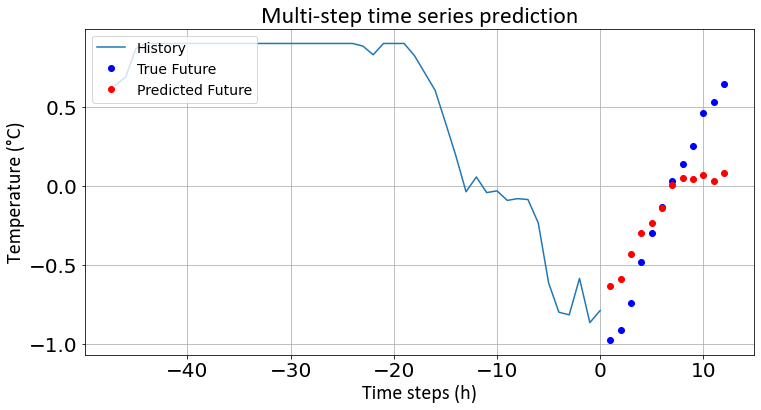

RMSE: 0.306
MAE: 0.250
ME: 0.559
SD: 0.306


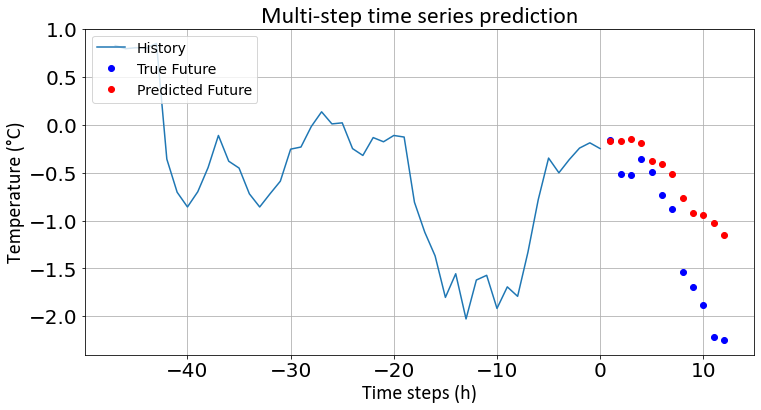

RMSE: 0.661
MAE: 0.540
ME: 1.189
SD: 0.661


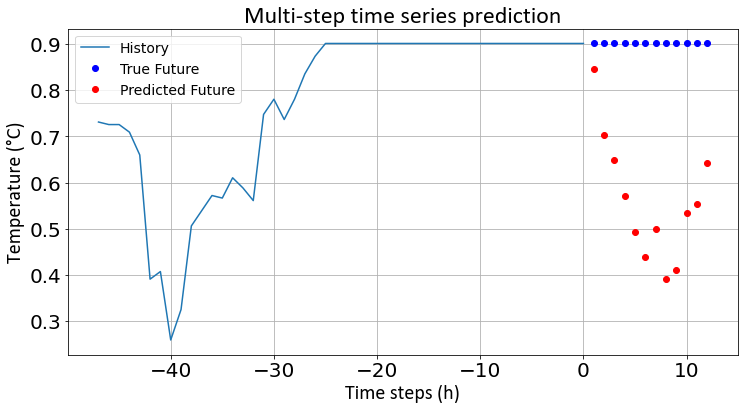

RMSE: 0.363
MAE: 0.340
ME: 0.510
SD: 0.363


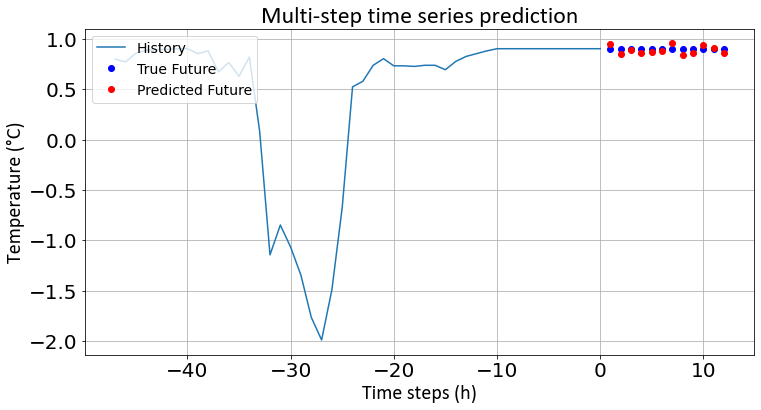

RMSE: 0.040
MAE: 0.037
ME: 0.066
SD: 0.040


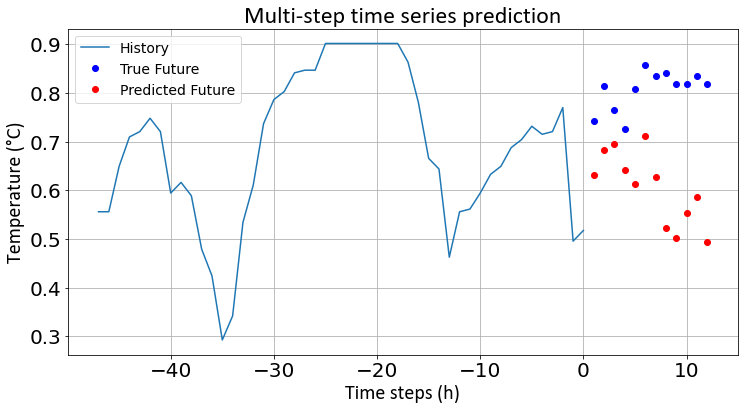

RMSE: 0.221
MAE: 0.202
ME: 0.326
SD: 0.221


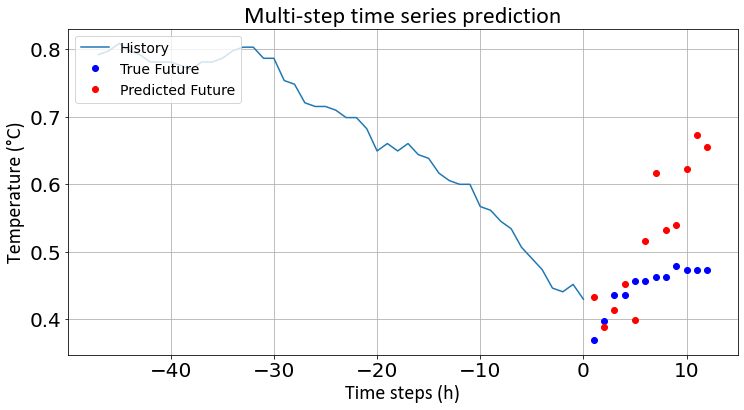

RMSE: 0.107
MAE: 0.086
ME: 0.199
SD: 0.107


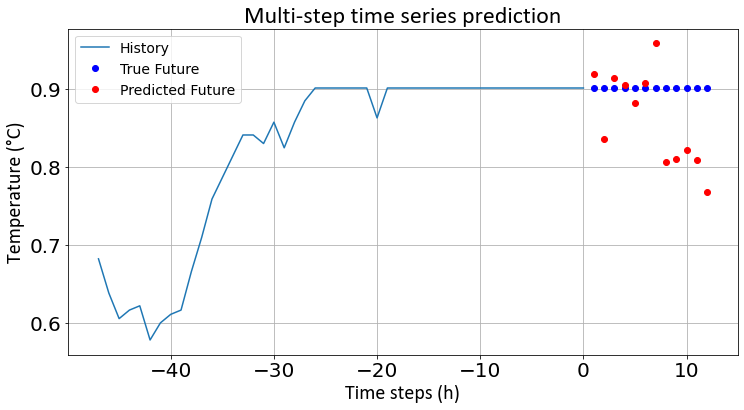

RMSE: 0.070
MAE: 0.056
ME: 0.133
SD: 0.070


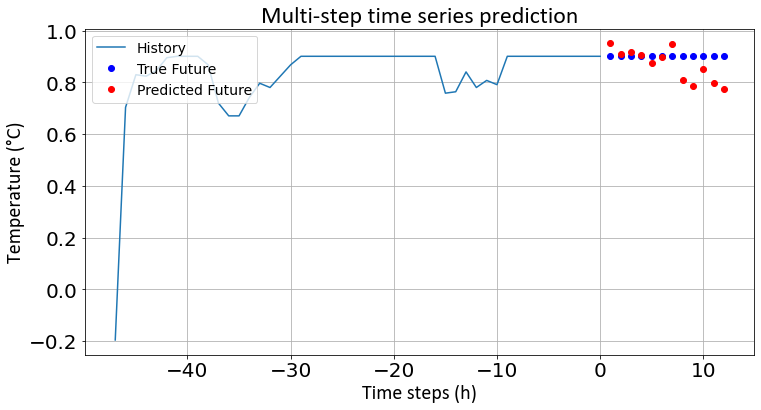

RMSE: 0.069
MAE: 0.054
ME: 0.128
SD: 0.069


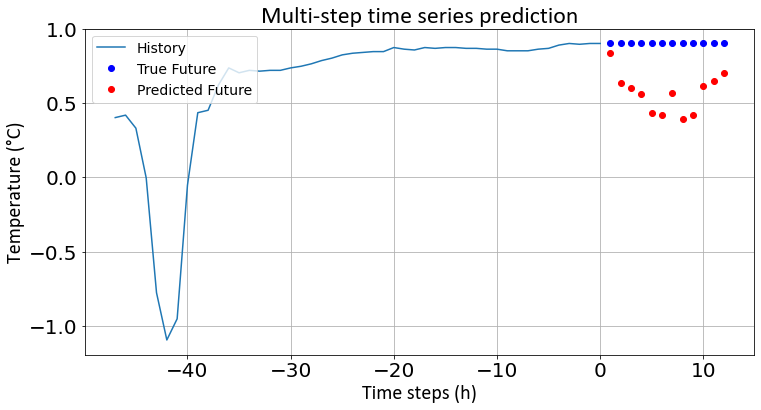

RMSE: 0.355
MAE: 0.331
ME: 0.510
SD: 0.355


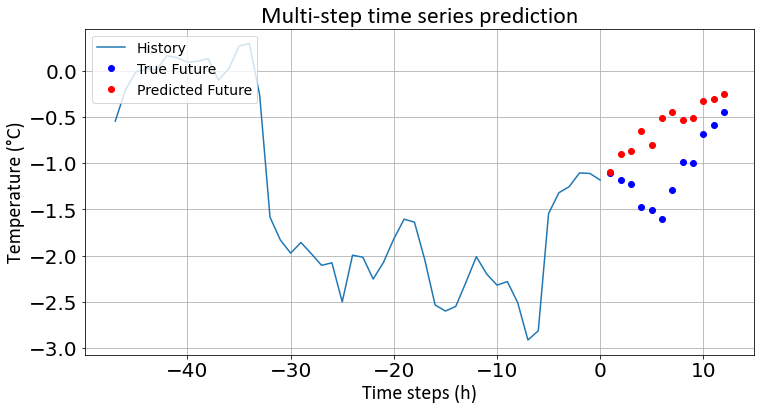

RMSE: 0.572
MAE: 0.488
ME: 1.083
SD: 0.572


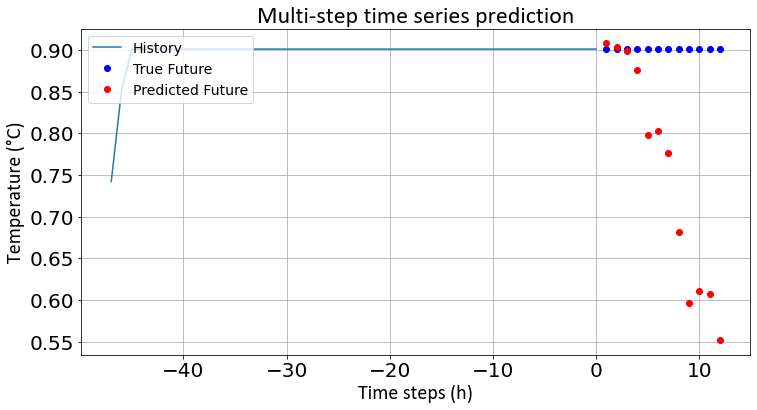

RMSE: 0.198
MAE: 0.152
ME: 0.349
SD: 0.198


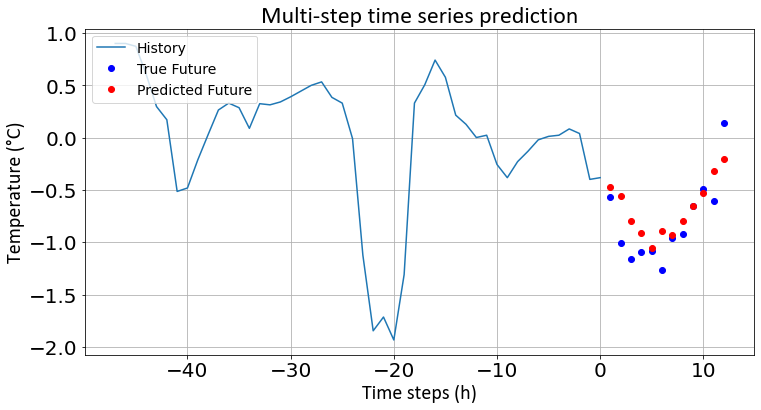

RMSE: 0.249
MAE: 0.195
ME: 0.451
SD: 0.249


In [18]:
for x, y in val_data_multi.take(50):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0], 'Multi-step time series prediction')
